# U-Net Experiement 1: Exploring variance/ randomness

When running the exact same model with the exact same dataset we get slightly different results each time due to randomness and variability involved in the training process.
the variance refers to 
The goal of this notebook is to evaluate the variability in the results obtained from different training runs on the same dataset We will use the exact same setup and dataset as in the unet notebook and execute 10 training runs.

### 0. Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')
! ls

Mounted at /content/drive
drive  sample_data


In [2]:
%cd drive/MyDrive/MachineLearning/
#! git clone https://github.com/emely3h/Geospatial_ML.git
%cd Geospatial_ML

#! git checkout feature/rerun-experiment-1-2
! ls

/content/drive/.shortcut-targets-by-id/15HUD3sGdfvxy5Y_bjvuXgrzwxt7TzRfm/MachineLearning
/content/drive/.shortcut-targets-by-id/15HUD3sGdfvxy5Y_bjvuXgrzwxt7TzRfm/MachineLearning/Geospatial_ML
architecture.drawio  evaluation   models	README.md
data_exploration     experiments  prepare_data	requirements.txt


In [3]:
! git pull

Already up to date.


In [3]:
from models.helpers import normalizing_encoding, define_model, train_model, save_model_history, make_predictions, save_metrics
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from models.unet_model import unet_2d
from models.helpers import get_mean_jaccard
from datetime import datetime
from prepare_data.create_mask import create_physical_mask
from evaluation.evaluation_metrics import EvaluationMetrics
import pickle
import tensorflow as tf
import matplotlib as plt

### 1. Loading + Preparing Data

In [4]:
root = "../data_colab/256_200/"

y_train  = np.load(os.path.join(root,'2022_06_20.npz'))['y_mask']
x_train  = np.load(os.path.join(root,'2022_06_20.npz'))['x_input']

y_val = np.load(os.path.join(root,'2022_07_10.npz'))['y_mask']
x_val = np.load(os.path.join(root,'2022_07_10.npz'))['x_input']

y_test = np.load(os.path.join(root, '2022_07_25.npz'))['y_mask']
x_test = np.load(os.path.join(root, '2022_07_25.npz'))['x_input']

print(y_train.shape)
print(x_train.shape)

print(y_val.shape)
print(x_val.shape)

print(y_test.shape)
print(x_test.shape)

(1251, 256, 256)
(1251, 256, 256, 5)
(1323, 256, 256)
(1323, 256, 256, 5)
(1258, 256, 256)
(1258, 256, 256, 5)


In [5]:
# Get physical prediction
train_physical = create_physical_mask(x_train)
val_physical = create_physical_mask(x_val)
test_physical = create_physical_mask(x_test)

print(train_physical.shape)
print(val_physical.shape)
print(test_physical.shape)

(1251, 256, 256, 3)
(1323, 256, 256, 3)
(1258, 256, 256, 3)


### 3. Normalizing + Encoding

In [6]:
x_train, y_train = normalizing_encoding(x_train, y_train)
X_val, y_val = normalizing_encoding(x_val, y_val)
x_test, y_test = normalizing_encoding(x_test, y_test)

y shape:  (1251, 256, 256)
Normalizing data...
y one hot shape:  (1251, 256, 256, 3)
y shape:  (1323, 256, 256)
Normalizing data...
y one hot shape:  (1323, 256, 256, 3)
y shape:  (1258, 256, 256)
Normalizing data...
y one hot shape:  (1258, 256, 256, 3)


### 4. Model summary

In [7]:
model = unet_2d(input_shape=(256, 256, 5), num_classes=3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 5  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  2944        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

### sync problem
Error: trying to devide by 0 during calculating precision metric

In [6]:
import numpy as np
from tensorflow import keras
import pickle


class EvaluationMetrics:
    """
        This class calculates and summarizes evaluation metrics based on the predicted and true labels.
    """

    def __init__(self, y_true, y_pred, y_physical):

        self.jaccard = self.jaccard_coef(y_true, y_pred)
        self.jaccard_physical =self.jaccard_coef(y_true, y_physical)

        print('conf matrix land')
        self.conf_matrix_land = self.confusion_matrix(y_true, y_pred, 2)
        print('conf matrix valid')
        self.conf_matrix_valid = self.confusion_matrix(y_true, y_pred, 1)
        print('conf matrix invalid')
        self.conf_matrix_invalid = self.confusion_matrix(y_true, y_pred, 0)

        print('precision land')
        self.precision_land = self.precision(self.conf_matrix_land)
        self.sensitivity_recall_land = self.sensitivity_recall(self.conf_matrix_land)
        self.specificy_land = self.specificy(self.conf_matrix_land)
        print('precision valid')
        self.precision_valid = self.precision(self.conf_matrix_valid)
        self.sensitivity_recall_valid = self.sensitivity_recall(self.conf_matrix_valid)
        self.specificy_valid = self.specificy(self.conf_matrix_valid)
        print('precision invalid')
        self.precision_invalid = self.precision(self.conf_matrix_invalid)
        self.sensitivity_recall_invalid = self.sensitivity_recall(self.conf_matrix_invalid)
        self.specificy_invalid = self.specificy(self.conf_matrix_invalid)

        self.f1_land = self.f1_scores(self.conf_matrix_land)
        self.f1_invalid = self.f1_scores(self.conf_matrix_invalid)
        self.f1_valid = self.f1_scores(self.conf_matrix_valid)

    def jaccard_coef(self, y_true, y_pred):
        y_true_f = keras.backend.flatten(y_true)
        y_pred_f = keras.backend.flatten(y_pred)

        intersection = keras.backend.sum(y_true_f * y_pred_f)
        return (intersection + 1.0) / (
                keras.backend.sum(y_true_f) + keras.backend.sum(y_pred_f) - intersection + 1.0
        )  # todo reason for +1?

    def jaccard_rounding_issue(self, y_true, y_pred):
        # revert one hot encoding => binary tensor [0, 0, 1] back to label [2] (3D array to 2D array)
        label_map_true = np.argmax(y_true, axis=-1)
        label_map_pred = np.argmax(y_pred, axis=-1)
        # convert 2D array into 1D array
        flatten_true = np.reshape(label_map_true, (-1,))
        flatten_pred = np.reshape(label_map_pred, (-1,))
        # one hot encoding
        one_hot_true = np.eye(3)[flatten_true]
        one_hot_pred = np.eye(3)[flatten_pred]
        # calculate intersection (A geschnitten B)
        intersection = np.sum(one_hot_true * one_hot_pred)
        # calculate union (a u B, A vereint B)
        union = len(one_hot_true) + len(one_hot_pred) - intersection
        # return jaccard coefficient
        return (intersection + 1) / (union + 1)

    def confusion_matrix(self, y_true, y_pred, label):
        true_positives = 0
        false_positives = 0
        true_negatives = 0
        false_negatives = 0

        # revert one hot encoding => binary tensor [0, 0, 1] back to label [2] (3D array to 2D array)
        label_map_true = np.argmax(y_true, axis=-1)
        label_map_pred = np.argmax(y_pred, axis=-1)
        # convert 2D array into 1D array
        flatten_true = np.reshape(label_map_true, (-1,))
        flatten_pred = np.reshape(label_map_pred, (-1,))

        tp_mask = (flatten_true == flatten_pred) & (flatten_true == label)
        true_positives = np.count_nonzero(tp_mask)

        fn_mask = (flatten_true == label) & (flatten_pred != label)
        false_negatives = np.count_nonzero(fn_mask)

        fp_mask = (flatten_true != label) & (flatten_pred == label)
        false_positives = np.count_nonzero(fp_mask)

        tn_mask = (flatten_true != label) & (flatten_pred != label)
        true_negatives = np.count_nonzero(tn_mask)
        print(f'print confusion matrix \n true_positives: {true_positives}, false_positives: {false_positives}, true_negatives: {true_negatives}, false_negatives: {false_negatives}')
        return {
            'true_positives': true_positives,
            'false_positives': false_positives,
            'true_negatives': true_negatives,
            'false_negatives': false_negatives
        }

    def precision(self, conf_matrix):
        print(f"entered precision: {conf_matrix['true_positives']} {(conf_matrix['true_positives'])} {conf_matrix['false_positives']}")
        return conf_matrix['true_positives'] / (conf_matrix['true_positives'] + conf_matrix['false_positives'])

    def sensitivity_recall(self, conf_matrix):
        return conf_matrix['true_positives'] / (conf_matrix['true_positives'] + conf_matrix['false_negatives'])

    def negative_predictive(self, conf_matrix):
        return conf_matrix['true_negatives'] / (conf_matrix['true_negatives'] + conf_matrix['false_negatives'])

    def specificy(self, conf_matrix):
        return conf_matrix['true_negatives'] / (conf_matrix['true_negatives'] + conf_matrix['false_positives'])

    def f1_scores(self, conf_matrix):
        prec = self.precision(conf_matrix)
        recall = self.sensitivity_recall(conf_matrix)
        return 2 * prec * recall / (prec + recall)

    def print_metrics(self):
        print(f'jaccard index: {self.jaccard} \n')
        print(f'physical jaccard: {self.jaccard_physical} \n')

        print(f'precision_land: {self.precision_land}')
        print(f'precision_valid: {self.precision_valid}')
        print(f'precision_invalid: {self.precision_invalid} \n')

        print(f'recall_invalid_land: {self.sensitivity_recall_land}')
        print(f'recall_invalid_land: {self.sensitivity_recall_valid}')
        print(f'recall_invalid_land: {self.sensitivity_recall_invalid} \n')

        print(f'specificy_invalid_land: {self.specificy_land}')
        print(f'specificy_invalid_valid: {self.specificy_valid}')
        print(f'specificy_invalid_invalid: {self.specificy_invalid} \n')

        print(f'f1_land: {self.f1_land}')
        print(f'f1_invalid: {self.f1_invalid}')
        print(f'f1_valid: {self.f1_valid}')
    # todo add pixel accuracy

def save_metrics(metrics_train, metrics_val, metrics_test, saving_path, count):
    with open(f'{saving_path}/metrics_test_{count}.pkl', 'wb') as file:
        pickle.dump(metrics_train, file)
    with open(f'{saving_path}/metrics_val_{count}.pkl', 'wb') as file:
        pickle.dump(metrics_val, file)
    with open(f'{saving_path}/metrics_train_{count}.pkl', 'wb') as file:
        pickle.dump(metrics_test, file)

### 5. Execute trainings + saving results

In [9]:
tile_size = 256
step_size = 200
experiment = 'experiment_1'
all_metrics_test = []
all_metrics_val = []
all_metrics_train = []

In [10]:
!nvidia-smi

Tue Apr  4 11:38:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    51W / 400W |    753MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
def execute_multiple_trainings(num_of_executions, epochs):
  print(f'Start: {datetime.now()}')
  for count in range(0, num_of_executions):
      
      model = define_model((256, 256, 5), 3)
      print(f'Start training number {count}')
      
      # Train model
      history = train_model(model, x_train, y_train, x_val, y_val, epochs=epochs)
      print('training completed')
      
      # Save model
      model_name = f'{tile_size}_{step_size}_run_{count}'
      model.save(f'../models/{experiment}/model_{model_name}.h5')
      print('saving model completed')
      
      # Save model history
      save_model_history(history, model_name, f'../models/{experiment}')
      print('saving history completed')
      
      # Predict 
      pred_train, pred_val, pred_test = make_predictions(model, x_train, x_val, x_test)
      print('prediction completed')



      metrics_train = EvaluationMetrics(y_train, pred_train, train_physical)
      metrics_val = EvaluationMetrics(y_val, pred_val, val_physical)
      metrics_test = EvaluationMetrics(y_test, pred_test, test_physical)
      
      print('metrics calculated')
      
      # Save metrics
      save_metrics(metrics_train, metrics_val, metrics_test, f'../metrics/{experiment}', count)

      print('saving metrics completed')
  
      print(f'Run {count} completed: {datetime.now()}')
  print(f'End: {datetime.now()}')
del model
execute_multiple_trainings(2, 100)

# executed with premium gpu and high ram => 13,08 computing units per hour, took

Start: 2023-04-04 11:39:44.008651
Start training number 0
Epoch 1/100
40/40 [==============================] - 42s 418ms/step - loss: 1.1997 - accuracy: 0.5090 - val_loss: 60.9759 - val_accuracy: 0.6333
Epoch 2/100
40/40 [==============================] - 10s 251ms/step - loss: 0.8120 - accuracy: 0.6317 - val_loss: 52.1781 - val_accuracy: 0.7664
Epoch 3/100
40/40 [==============================] - 10s 251ms/step - loss: 0.8759 - accuracy: 0.5493 - val_loss: 135.1104 - val_accuracy: 0.5106
Epoch 4/100
40/40 [==============================] - 10s 251ms/step - loss: 0.7803 - accuracy: 0.6347 - val_loss: 113.9156 - val_accuracy: 0.5197
Epoch 5/100
40/40 [==============================] - 10s 252ms/step - loss: 0.9934 - accuracy: 0.5231 - val_loss: 133.7400 - val_accuracy: 0.4257
Epoch 6/100
40/40 [==============================] - 10s 252ms/step - loss: 0.8144 - accuracy: 0.6132 - val_loss: 313.3511 - val_accuracy: 0.6111
Epoch 7/100
40/40 [==============================] - 10s 252ms/step 

### 6. Histories + Metrics 

In [4]:
history_path = '../models/experiment_1/'

def get_histories_of_experiment(history_path):
  histories = []
  for file in os.listdir(history_path):
    if file.startswith('history'):
      print(f'Adding: {file}')
      with open(os.path.join(history_path, file), 'rb') as f:
        data = pickle.load(f)
        histories.append(data)
  return histories


histories = get_histories_of_experiment(history_path)
print(f'Total amount of model histories: {len(histories)}')

Adding: history_256_200_run_0.pkl
Adding: history_256_200_run_1.pkl
Total amount of model histories: 2


In [5]:
metric_path = '../metrics/experiment_1/'


def get_metrics_of_experiment(metric_path):
  training_metrics = []
  validation_metrics = []
  test_metrics = []

  for file in os.listdir(metric_path):
    if file.startswith('metrics'):
      print(file)

      with open(os.path.join(metric_path, file), 'rb') as f:
        data = pickle.load(f)
        data_set = file.split('_')[1]

        if data_set.startswith('train'):
          training_metrics.append(data)
        elif data_set.startswith('val'):
          validation_metrics.append(data)
        elif data_set.startswith('test'):
          test_metrics.append(data)
  return training_metrics, validation_metrics, test_metrics

training_metrics, validation_metrics, test_metrics = get_metrics_of_experiment(metric_path)

print(len(training_metrics))
print(len(validation_metrics))
print(len(test_metrics))


metrics_test.pkl
metrics_test_0.pkl
metrics_test_1.pkl
metrics_val.pkl
metrics_train.pkl
1
1
3


In [65]:
import matplotlib.pyplot as plt

def plot_loss_acc(plots, y_scale, model_history, scale):
  loss = model_history['loss']
  val_loss = model_history['val_loss']
  acc = model_history['accuracy']
  val_acc = model_history['val_accuracy']

  plt.figure(figsize=(10,6))
  if 'loss' in plots:
    plt.plot(loss, 'g', label='Training Loss')
  
  if 'accuracy' in plots:
    plt.plot(acc, 'y', label='Training Accuracy')
  
  if 'val_loss' in plots:
    plt.plot(val_loss, 'r', label='Validation Loss')
  
  if 'val_accuracy' in plots:
    plt.plot(val_acc, 'b', label='Validation Accuracy')

  plt.xlabel('Epoch')
  plt.ylabel('Value')
  plt.ylim(scale)

  plt.legend()

  plt.show()


In [13]:
def print_all_metrics(metric, data_set):
  print(f'========= {data_set} ==========')  
  metric.print_metrics()
  print()
  print()

In [63]:
def print_history_metrics_for_run(history, training_metrics, validation_metrics, test_metrics, scale_all, scale_loss, scale_acc):
  plot_loss_acc(['loss', 'accuracy', 'val_loss', 'val_accuracy'], 'all', history, scale_all)

  plot_loss_acc(['loss', 'val_loss',], 'loss', history, scale_loss)
  print()
  plot_loss_acc(['accuracy', 'val_accuracy'], 'accuracy', history, scale_acc)
  print()

  print_all_metrics(training_metrics, 'TRAINING SET')
  print()
  print()
  print_all_metrics(validation_metrics, 'VALIDATION SET')
  print()
  print()
  print_all_metrics(test_metrics, 'TEST SET')

#### Run 1

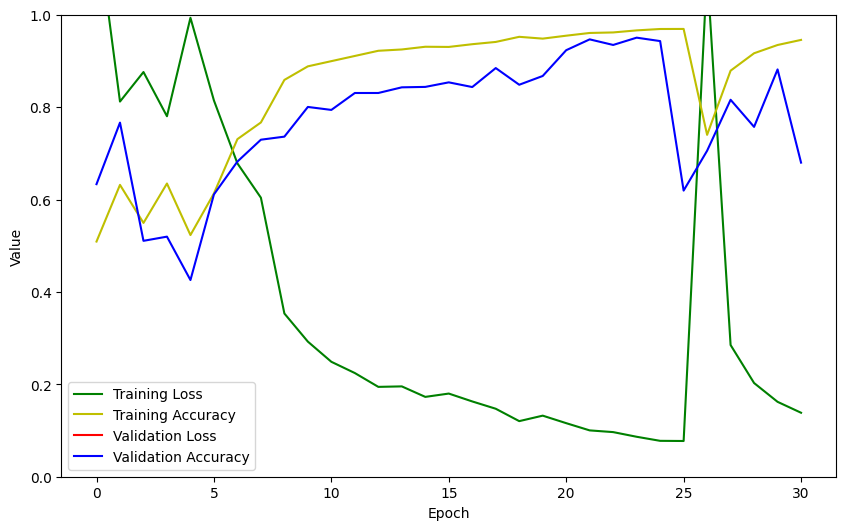

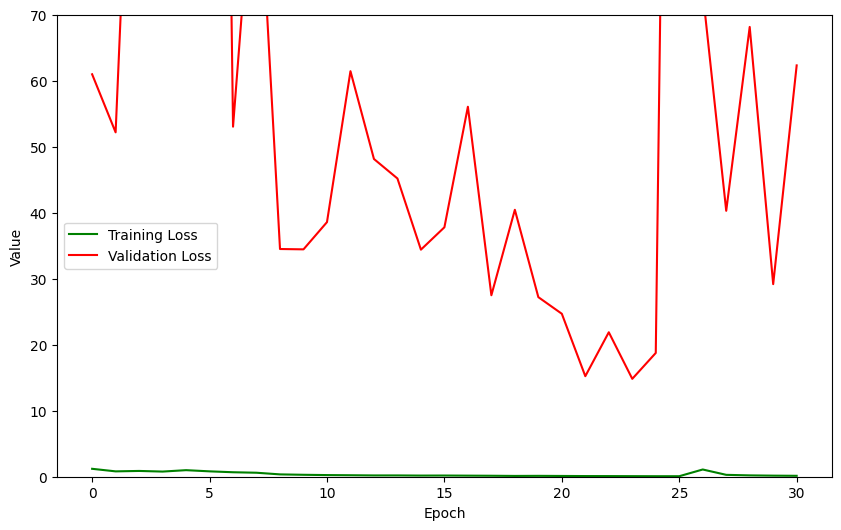

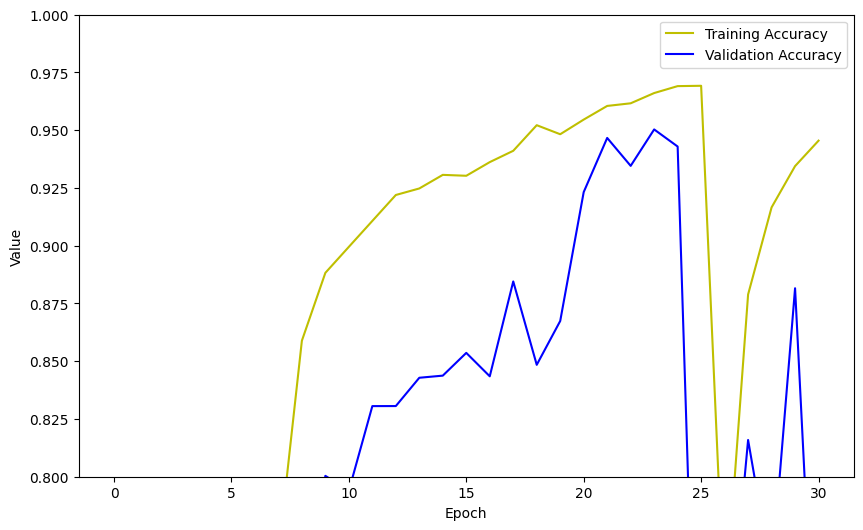


========= TRAINING SET ==========
jaccard index: 0.7719394564628601 

physical jaccard: 0.9383465051651001 

precision_land: 0.9413003226197453
precision_valid: 0.9204782460788433
precision_invalid: 0.48484581328086107 

recall_invalid_land: 0.9575551390932787
recall_invalid_land: 0.9711253220178562
recall_invalid_land: 0.23892451276180018 

specificy_invalid_land: 0.9475021376553883
specificy_invalid_valid: 0.9268734268613723
specificy_invalid_invalid: 0.981930971551306 

f1_land: 0.949358157615179
f1_invalid: 0.3201058278697666
f1_valid: 0.9451237544800949




========= VALIDATION SET ==========
jaccard index: 0.603445827960968 

physical jaccard: 0.9339901208877563 

precision_land: 0.9448255756650278
precision_valid: 0.874271867950401
precision_invalid: 0.5352879739918565 

recall_invalid_land: 0.7076600826179025
recall_invalid_land: 0.7282905330782821
recall_invalid_land: 0.8527892203012021 

specificy_invalid_land: 0.9688500760189128
specificy_invalid_valid: 0.9544684750698563
s

In [68]:
run = 0
print_history_metrics_for_run(histories[run], training_metrics[run], validation_metrics[run], test_metrics[run], [0,1], [0, 70], [0.8, 1])

#### Run 2

In [69]:
run = 1
print_history_metrics_for_run(histories[run], training_metrics[run], validation_metrics[run], test_metrics[run], [0,1], [0, 70], [0.8, 1])

IndexError: ignored

#### Run 3

In [ ]:
run = 2
print_history_metrics_for_run(histories[run], training_metrics[run], validation_metrics[run], test_metrics[run], [0,1], [0, 70], [0.8, 1])

#### Run 4

In [ ]:
run = 3
print_history_metrics_for_run(histories[run], training_metrics[run], validation_metrics[run], test_metrics[run], [0,1], [0, 70], [0.8, 1])

#### Run 5

#### Run 6

#### Run 7

#### Run 8

#### Run 9

#### Run 10

### 7. Summary

In [70]:
print('============ TEST DATA ===================')
get_mean_jaccard(training_metrics)
print()

print('============ VALIDATION DATA ===================')
get_mean_jaccard(validation_metrics)
print()

print('============ TRAINING DATA ===================')
get_mean_jaccard(test_metrics)
print()

============ TEST DATA ===================
tf.Tensor(0.77193946, shape=(), dtype=float32)

Mean jaccard index: 0.07719394564628601

Worst index: 0.7719394564628601
Best index: 0.7719394564628601
Variance: 0.0

============ VALIDATION DATA ===================
tf.Tensor(0.6034458, shape=(), dtype=float32)

Mean jaccard index: 0.06034458428621292

Worst index: 0.603445827960968
Best index: 0.603445827960968
Variance: 0.0

============ TRAINING DATA ===================
tf.Tensor(0.84227985, shape=(), dtype=float32)
tf.Tensor(0.87535644, shape=(), dtype=float32)
tf.Tensor(0.7193665, shape=(), dtype=float32)

Mean jaccard index: 0.2437002956867218

Worst index: 0.7193664908409119
Best index: 0.8753564357757568
Variance: 0.15598994493484497

